In [262]:
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
import scipy.fftpack

np.random.seed(666)

Variable initialization

In [263]:
M = 32 # signal dimension
N = 2 * M # number of atoms in the expansion

C = np.zeros((M, M)) # matrix containing the standard basis (a kronecker delta in each column)
DCT = np.zeros((M, M)) #matrix containing the DCT basis (a DCT function in each column)

Generate the 1D-DCT basis

In [264]:
for i in range(M):
   DCT[:, i] = sp.fftpack.idct(np.eye(M)[i], norm='ortho')

Generating the 1-D standard basis

In [265]:
for i in range(M):
   C[:, i] = np.eye(M)[i]

Define the dictionary $D = [DCT, C]$

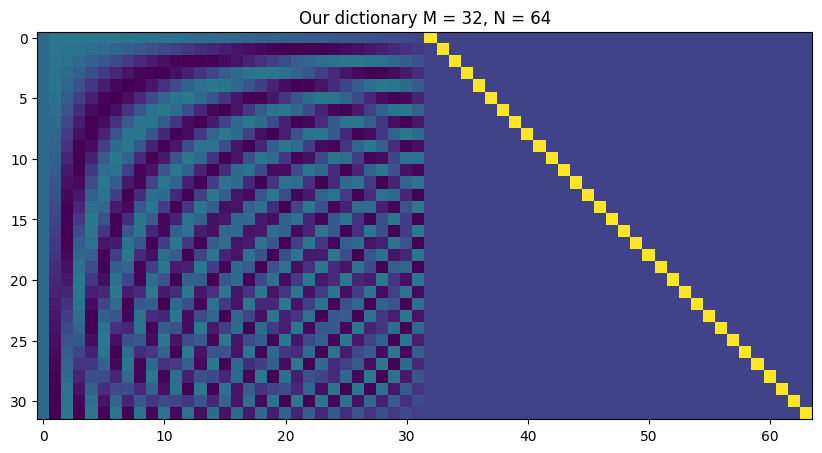

In [266]:
D = np.hstack((DCT, C))

plt.figure(figsize=(10,10))
plt.imshow(D)
plt.title(f'Our dictionary M = {M}, N = {N}');

Generate a signal that is sparse w.r.t. $D$
-----------------------------------------
To this purpose add a spike to the sum of few DCT atoms, i.e., add a spike to s that is sparse w.r.t. D. Bear in mind that the spike is to be considered a signal to be reconstructed, rather than noise

In [267]:
L = 4
sigma_noise = 0.2

Randomly define the coefficients of a sparse representation w.r.t. $D$ (make sure the nonzero coefficients are sufficiently large)

In [268]:
x0 = np.zeros(N)
x0[np.random.choice(M, L - 1, replace=False)] = 1

Choose spike location

In [269]:
spikeLocation = np.random.choice(M, 1)
x0[M + spikeLocation] = np.random.normal(2, 1)

Synthetize the corresponding signal in the signal domain and add noise


In [270]:
s0 = D @ x0
s = s0 + np.random.normal(0, sigma_noise, M)

Plot the sparse signal

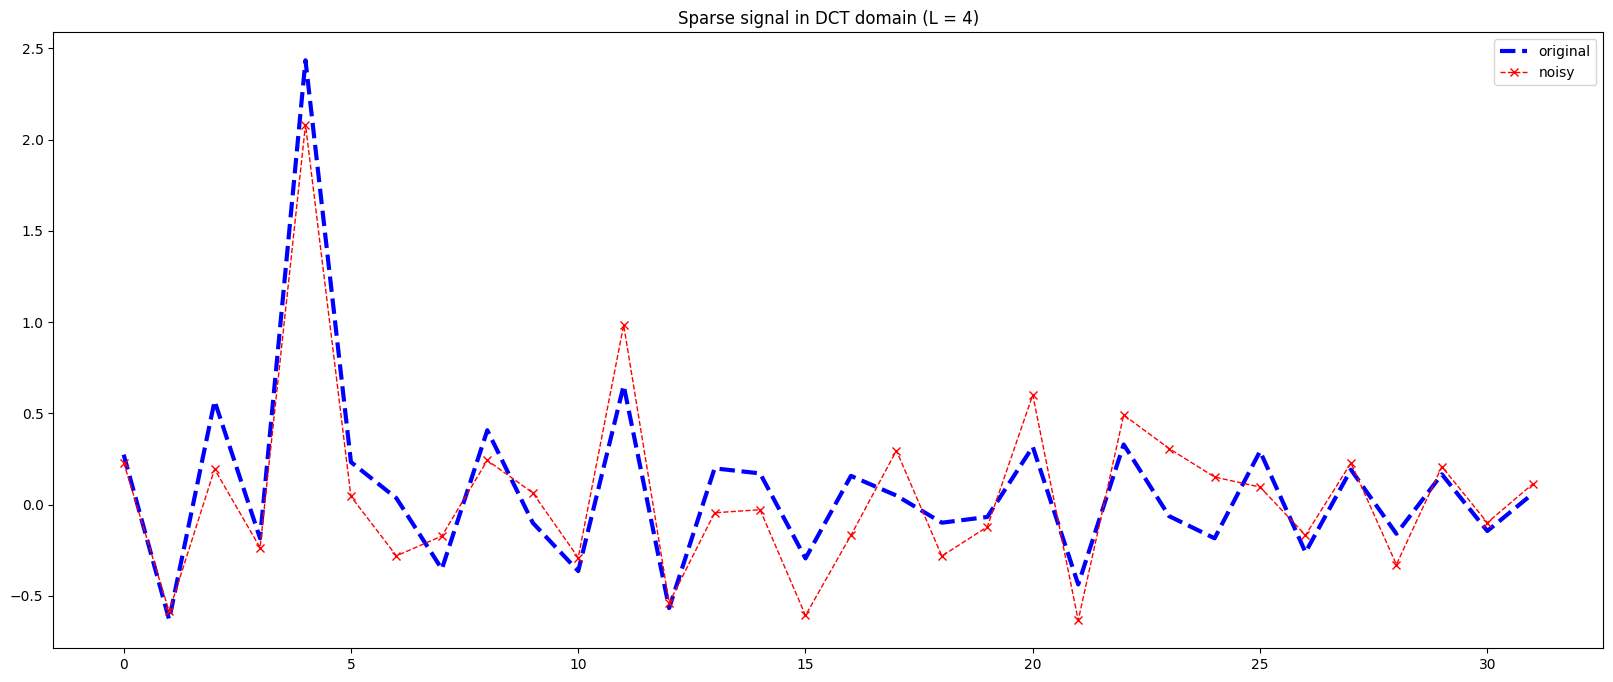

In [271]:
LN_WDT = 2
MRK_SZ = 10

plt.figure(figsize=(20, 8))
plt.plot(s0, 'b--', linewidth=LN_WDT+1)
plt.plot(s, 'r--x', linewidth=LN_WDT-1)
plt.title(f'Sparse signal in DCT domain (L = {L:.0f})')
plt.legend(['original', 'noisy']);

Orthogonal Matching Pursuit
---------------------------

Initialize all the variables, including the residual, namely the components of the signals that can not be represented (here the signal at the very beginning)

In [272]:
x_OMP = np.zeros(N)

# residual
r = s

# support set
omega = []

MINIMUM_NORM_RES = 0.1

OMP loop starts.

Stoppint criteria: continue until the sparsity of the representation reaches L

In [273]:
while np.linalg.norm(r) > MINIMUM_NORM_RES and np.sum(x_OMP != 0) < min(L, M):
    # SWEEP STEP: look for the column of D that matches at best noisySignal
    # compute the residual w.r.t. each column of D
    e = np.zeros(N)
    for j in range(N):
        e[j] = np.dot(r, r) - np.dot(r, D[:, j])

    # find the column of D that matches at best r
    jStar = np.argmin(e)

    # UPDATE the support set with the jStar coefficient
    omega.append(jStar)

    # update the coefficients by solving the least square problem min ||D_omega x - s ||
    D_omega = D[:, omega]
    x_OMP = np.zeros(N)
    x_OMP[omega] = np.linalg.inv(D_omega.T @ D_omega) @ D_omega.T @ s

    # update the residual
    r = s - D_omega @ x_OMP[omega]

SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [274]:
D.shape, x_OMP.shape

((32, 64), (64,))

In [275]:
s_hat_OMP = D @ x_OMP

Show the result

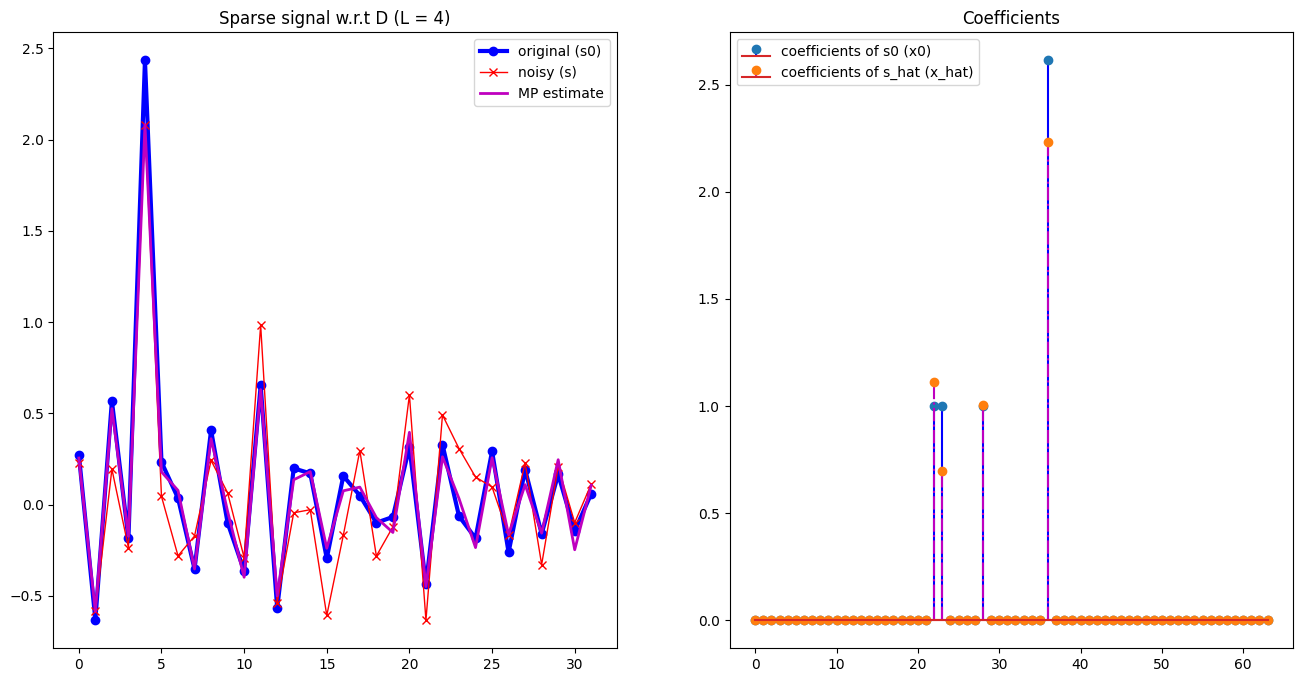

In [276]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(s0, 'b-o', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_OMP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t D (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_OMP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)']);

Least Squares Orthogonal Matching Pursuit
-----------------------------------------

Initialize all the variables, including the residual, namely the components of the signals that can not be represented (here the signal at the very beginning)

In [277]:
x_LSOMP = np.zeros(N)

# residual
r = s

# support set
omega = []

resNorm = np.linalg.norm(r)

MINIMUM_NORM_RES = 0.1

LSOMP loop starts.

Stoppint criteria: continue until the sparsity of the representation reaches L

In [278]:
while np.sum(x_LSOMP != 0) < min(L, M) and resNorm > MINIMUM_NORM_RES:
    tmp = {}
    for j in [k for k in range(N) if k not in omega]:
        omega_j = omega + [j]
        z = np.linalg.inv(D[:, omega_j].T @ D[:, omega_j]) @ D[:, omega_j].T @ s
        e = np.linalg.norm(s - D[:, omega_j] @ z) ** 2
        tmp[j] = (e, z)
    e = np.array([np.inf for _ in range(N)])
    for j in tmp:
        e[j] = tmp[j][0]
    jStar = np.argmin(e)
    omega.append(jStar)
    x = tmp[jStar][1]
    x_LSOMP = np.zeros(N)
    x_LSOMP[omega] = x

    r = s - D[:, omega] @ x_LSOMP[omega]
    resNorm = np.linalg.norm(r)

SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [279]:
s_hat_LSOMP = D @ x_LSOMP

Show the result

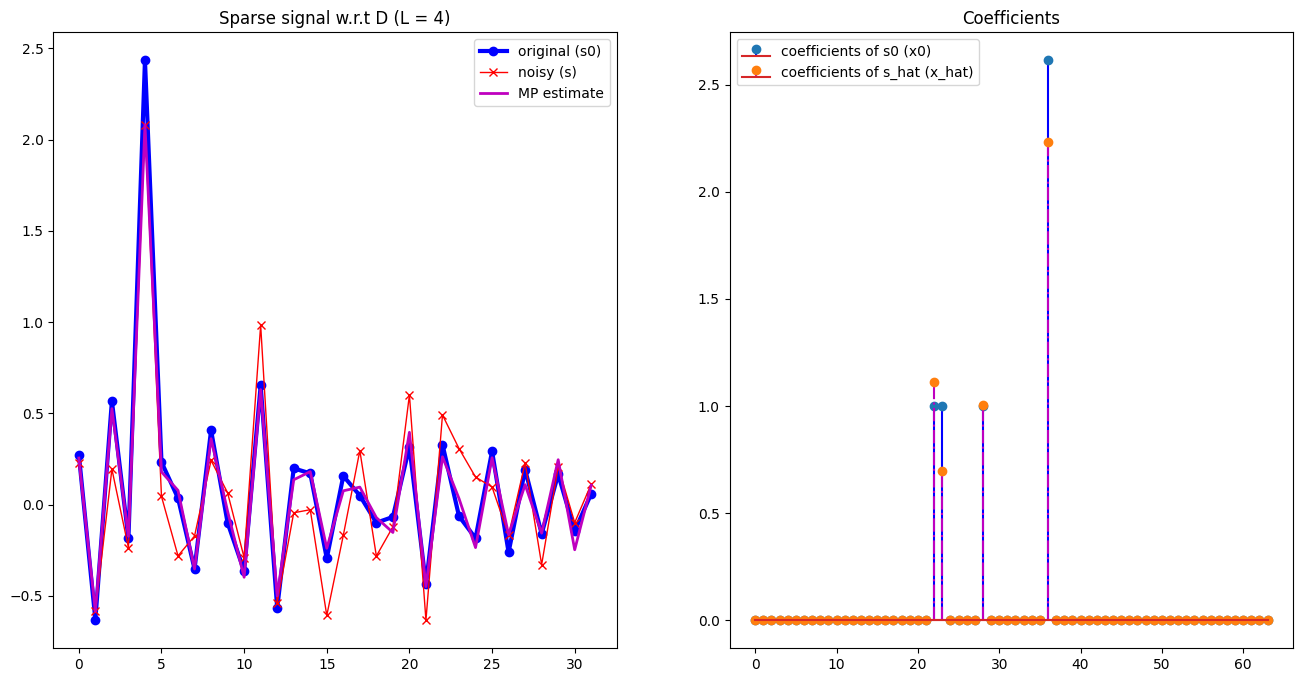

In [280]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(s0, 'b-o', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_LSOMP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t D (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_LSOMP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)']);